## Extending Linear Regression by Transforming Predictors

In [1]:
# Data and Stats packages
import numpy as np
import pandas as pd
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm 

# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (8, 6.0)

# Other Helpful fucntions
import warnings
warnings.filterwarnings("ignore")

#Aesthetic settings
from IPython.display import display
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)

Linear regression works great when our features are all continuous and all linearly affect the output. But often real data have more interesting characteristics. Here, we'll look at how we can extend linear regression to handle:

* Categorical predictors, like gender, which have one of a few discrete values
* Interactions between predictors, which let us model how one variable changes the effect of another.

For our dataset, we'll be using the passenger list from the Titanic, which famously sank in 1912. Let's have a look at the data. Some descriptions of the data are at https://www.kaggle.com/c/titanic/data, and here's [how seaborn preprocessed it](https://github.com/mwaskom/seaborn-data/blob/master/process/titanic.py).

In [2]:
# you can also load the dataset from seaborn 
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Note:
sns.load_dataset("titanic") load_dataset function loads data from a predefined set of datasets hosted by Seaborn, while Pandas' read_csv function can load data from any CSV file specified by the user.

sns.load_dataset("titanic") uses the Seaborn library (sns),it provides an interface to load example datasets that are hosted in its online repository.

When you call sns.load_dataset("titanic"), it accesses the Titanic dataset from the Seaborn's online repository, downloads it (if not already cached), and returns a Pandas DataFrame.

Seaborn's load_dataset specifically loads datasets that are already formatted and stored in a way that's compatible with Seaborn's data structure requirements, whereas pd.read_csv can read any text file that is structured as a CSV, allowing for more customization in terms of data source and structure.

In [3]:
# Keep only a subset of the predictors; some are redundant, others (like deck) have too many missing values.
titanic = titanic[['age', 'sex', 'class', 'embark_town', 'alone', 'fare']]

In [4]:
# check the general information through titanic.info()
print(titanic.info())
titanic.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          714 non-null    float64 
 1   sex          891 non-null    object  
 2   class        891 non-null    category
 3   embark_town  889 non-null    object  
 4   alone        891 non-null    bool    
 5   fare         891 non-null    float64 
dtypes: bool(1), category(1), float64(2), object(2)
memory usage: 29.8+ KB
None


,age,sex,class,embark_town,alone,fare
0,22.0,male,Third,Southampton,False,7.2500
1,38.0,female,First,Cherbourg,False,71.2833
2,26.0,female,Third,Southampton,True,7.9250
3,35.0,female,First,Southampton,False,53.1000
4,35.0,male,Third,Southampton,True,8.0500


In [5]:
# Drop missing data, the regression model cannot handle NaN value
titanic = titanic.dropna()
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          712 non-null    float64 
 1   sex          712 non-null    object  
 2   class        712 non-null    category
 3   embark_town  712 non-null    object  
 4   alone        712 non-null    bool    
 5   fare         712 non-null    float64 
dtypes: bool(1), category(1), float64(2), object(2)
memory usage: 29.3+ KB


First let's look at the distribution of fares.

<div class="exercise">**Exercise 1**: Show the distribution of fares in at least two ways. You may use functions from matplotlib, Pandas, or Seaborn.</div>

In [6]:
# Your code here
titanic.fare.describe()
#titanic['fare'].desrcibe()

count    712.000000
mean      34.567251
std       52.938648
min        0.000000
25%        8.050000
50%       15.645850
75%       33.000000
max      512.329200
Name: fare, dtype: float64

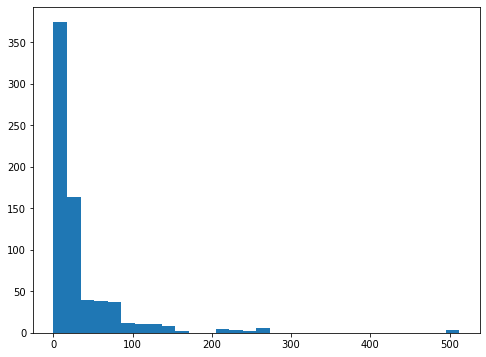

In [7]:
# Your code here
plt.hist(titanic['fare'],bins=30)
plt.show()

<Axes: xlabel='fare', ylabel='Count'>

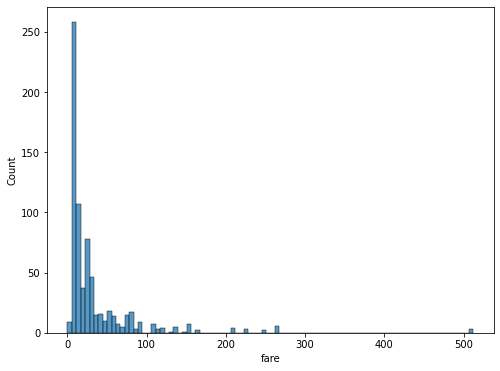

In [8]:
sns.histplot( data=titanic, x='fare')

<Axes: xlabel='fare', ylabel='Count'>

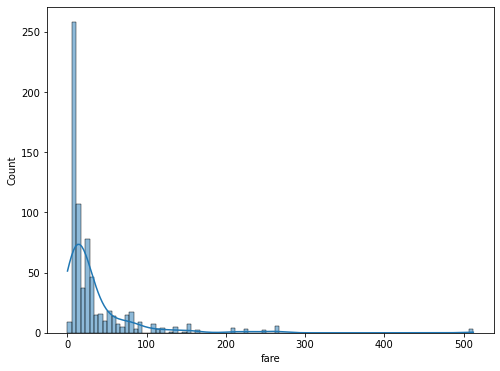

In [9]:
sns.histplot( data=titanic, x='fare', kde=True)

<Axes: xlabel='fare', ylabel='Count'>

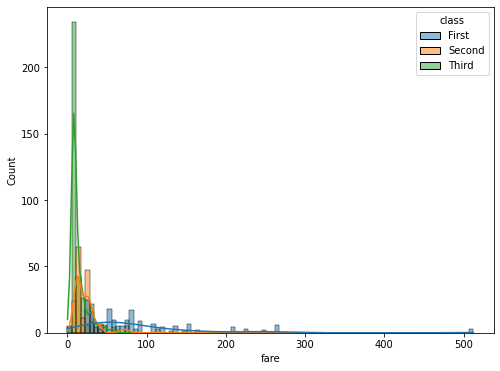

In [10]:
sns.histplot(data=titanic, x='fare', kde=True, hue='class')

### Exploring predictors

Cabin class is probably going to matter for fare, but we might wonder if age and gender also matter. Let's explore them.

<Axes: xlabel='age', ylabel='Density'>

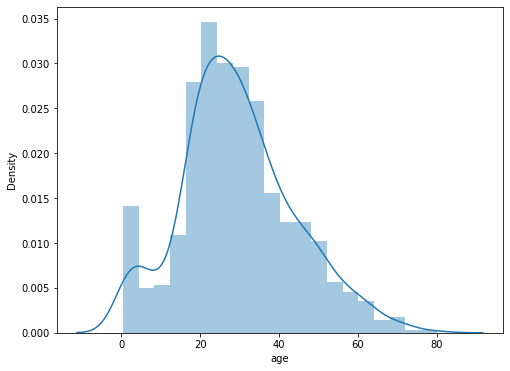

In [11]:
sns.distplot(titanic.age)

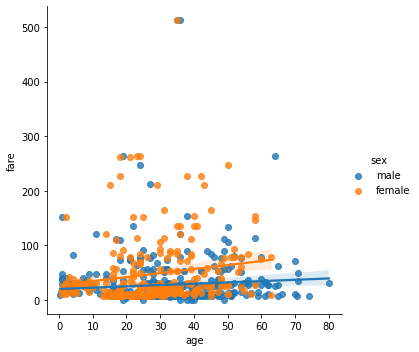

In [12]:
sns.lmplot(x="age", y="fare", hue="sex", data=titanic)

Hmm... the slopes seem to be different for males and females. Remember this for later.

How about class?

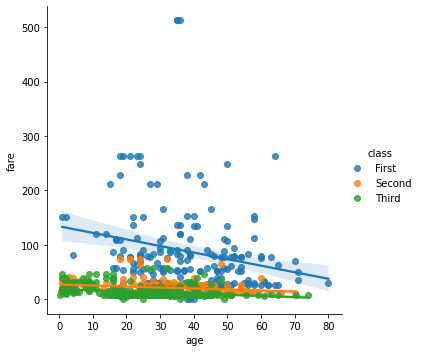

In [13]:
sns.lmplot(x="age", y="fare", hue="class", data=titanic)

So it looks like fare varies with class, age, and maybe gender, and the way that fare depends on class and age may be different for male vs female.

Let's first do a simple linear regression on age.

In [14]:
model1 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic['age'])
).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.214
Date:                Tue, 16 Apr 2024   Prob (F-statistic):             0.0129
Time:                        18:32:12   Log-Likelihood:                -3832.7
No. Observations:                 712   AIC:                             7669.
Df Residuals:                     710   BIC:                             7679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4823      4.503      5.437      0.000      15.642      33.323
age            0.3402      0.136      2.493      0.013       0.072       0.608
==============================================================================
Omnibus:                      715.959   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30912.718
Skew:                           4.664   Prob(JB):                         0.00
Kurtosis:                      33.903   Cond. No.                         75.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

How do we interpret this?

* How good is this model?
* Does age affect fare? How can we tell? And if so, how? 

But Class and Gender are categorical variables

### Handling categorical variables

How do we deal with gender, or class? They're categorical variables. We'll need to use dummy variables to encode them.

In [15]:
titanic_orig = titanic.copy()

**Exercise 2**: Create a column [`sex_male`] that is 1 if the passenger is male, 0 otherwise.

In [16]:
# Your code here
titanic['sex_male'] = (titanic.sex == 'male').astype(int)

#titanic.sex == 'male': This is a condition that checks each entry in the sex column of the titanic DataFrame. 
# The expression evaluates to True where the sex is 'male', and False otherwise. 
# The result of this expression is a Boolean Series.
#.astype(int): This method converts the Boolean values (True and False) of the Series obtained from the comparison to integers. 
# In Python, True converts to 1 and False converts to 0

Exercise 3: Do we need a ['sex_female'] column, or any others? Why or why not?

**your answer here**

No, because it's redundant: the only values for `sex` in this dataset are `male` and `female`, so if a passenger is not male, we know they're female.

Exercise 4**: Create columns for [`class_`]

In [17]:
# Your code here
titanic['class_Second'] = (titanic['class'] == 'Second').astype(int)
titanic['class_Third'] = 1 * (titanic['class'] == 'Third') # just another way to do it

# 1 * (titanic['class'] == 'Third')`**: This operation multiplies each element of the Boolean Series by 1. 
# In Python, Boolean values are also treated as numeric in arithmetic operations, 
# with `True` being equivalent to `1` and `False` to `0`. 
# Therefore, multiplying by 1 effectively converts `True` to `1` and `False` to `0`.



In [18]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           712 non-null    float64 
 1   sex           712 non-null    object  
 2   class         712 non-null    category
 3   embark_town   712 non-null    object  
 4   alone         712 non-null    bool    
 5   fare          712 non-null    float64 
 6   sex_male      712 non-null    int64   
 7   class_Second  712 non-null    int64   
 8   class_Third   712 non-null    int64   
dtypes: bool(1), category(1), float64(2), int64(3), object(2)
memory usage: 62.2+ KB


We can also use pd.get_dummies to do the job

In [19]:
# Your code here
# This function automates the above:
titanic = pd.get_dummies(titanic_orig, columns=['sex', 'class'], drop_first=True)

titanic.head()

,age,embark_town,alone,fare,sex_male,class_Second,class_Third
0,22.0,Southampton,False,7.2500,1,0,1
1,38.0,Cherbourg,False,71.2833,0,0,0
2,26.0,Southampton,True,7.9250,0,0,1
3,35.0,Southampton,False,53.1000,0,0,0
4,35.0,Southampton,True,8.0500,1,0,1


In [20]:
# `pd.get_dummies(titanic_orig, ...)`**: 
# This function is used to convert categorical variable(s) into dummy/indicator variables, which is also known as one-hot encoding.
# This function call processes the `titanic_orig` DataFrame according to the specified parameters, 
# creating a new DataFrame with the original data plus the new dummy columns for the specified categorical columns.
# **`drop_first=True`**: This parameter controls whether to get k-1 dummies out of k categorical levels by removing the first level. This is used to avoid multicollinearity in the resulting dataset, which can be a problem in certain statistical models, particularly linear models. By setting `drop_first=True`, the function drops the first category in each specified column. For example:
#  If `sex` originally contains 'male' and 'female', with `drop_first=True`, only one column (e.g., `sex_male`) would be created where 'male' is represented as 1 and 'female' as 0 (assuming 'female' is the first category).


**Exercise 5**: Fit a linear regression including the new sex and class variables.</div>

Hint: use titanic[['age', 'sex_male', 'class_Second', 'class_Third'] as the X variables

In [21]:
# Your code here
model2 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic[['age', 'sex_male', 'class_Second', 'class_Third']])
).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     110.9
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           2.25e-73
Time:                        18:32:12   Log-Likelihood:                -3662.4
No. Observations:                 712   AIC:                             7335.
Df Residuals:                     707   BIC:                             7358.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          110.9658      5.485     20.229      0.000     100.196     121.736
age             -0.4513      0.117     -3.841      0.000      -0.682      -0.221
sex_male       -10.4196      3.329     -3.130      0.002     -16.956      -3.883
class_Second   -70.0469      4.515    -15.514      0.000     -78.911     -61.182
class_Third    -78.9638      4.145    -19.051      0.000     -87.102     -70.826
==============================================================================
Omnibus:                      804.007   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70017.197
Skew:                           5.349   Prob(JB):                         0.00
Kurtosis:                      50.388   Cond. No.                         150.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class='exercise'> **Exercise 6** How do we interpret these results?</div>
* All else being equal, what does being male do to the fare?
* What can we say about being *male* and *first-class*?


## Interactions

In [22]:
# It seemed like gender interacted with age and class. Can we put that in our model?
titanic['sex_male_X_age'] = titanic['age'] * titanic['sex_male']


In [23]:
# fit the model with the interaction term

model3 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age']])
).fit()

model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     90.21
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           2.26e-73
Time:                        18:32:12   Log-Likelihood:                -3659.9
No. Observations:                 712   AIC:                             7332.
Df Residuals:                     706   BIC:                             7359.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            101.7891      6.868     14.821      0.000      88.305     115.273
age               -0.1195      0.190     -0.628      0.530      -0.493       0.254
sex_male           4.0310      7.334      0.550      0.583     -10.367      18.429
class_Second     -70.2038      4.503    -15.590      0.000     -79.045     -61.362
class_Third      -78.9242      4.134    -19.093      0.000     -87.040     -70.809
sex_male_X_age    -0.5030      0.228     -2.210      0.027      -0.950      -0.056
==============================================================================
Omnibus:                      808.727   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            71826.587
Skew:                           5.397   Prob(JB):                         0.00
Kurtosis:                      51.006   Cond. No.                         241.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

** What happened to the `age` and `male` terms? **

In [24]:
# It seemed like gender interacted with age and class. Can we put that in our model?
titanic['sex_male_X_class_Second'] = titanic['age'] * titanic['class_Second']
titanic['sex_male_X_class_Third'] = titanic['age'] * titanic['class_Third']

model4 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 'sex_male_X_class_Second', 'sex_male_X_class_Third']])
).fit()

model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     67.80
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           1.23e-74
Time:                        18:32:12   Log-Likelihood:                -3652.4
No. Observations:                 712   AIC:                             7321.
Df Residuals:                     704   BIC:                             7357.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     127.2774      9.446     13.474      0.000     108.732     145.823
age                        -0.7991      0.257     -3.107      0.002      -1.304      -0.294
sex_male                    4.0819      7.266      0.562      0.574     -10.185      18.348
class_Second             -104.1076     11.219     -9.280      0.000    -126.134     -82.081
class_Third              -112.1375      9.787    -11.458      0.000    -131.352     -92.923
sex_male_X_age             -0.4864      0.226     -2.156      0.031      -0.929      -0.043
sex_male_X_class_Second     0.9504      0.305      3.120      0.002       0.352       1.549
sex_male_X_class_Third      0.9728      0.270      3.602      0.000       0.443       1.503
==============================================================================
Omnibus:                      812.510   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75162.969
Skew:                           5.424   Prob(JB):                         0.00
Kurtosis:                      52.152   Cond. No.                         445.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What has happened to the $R^2$ as we added more features?

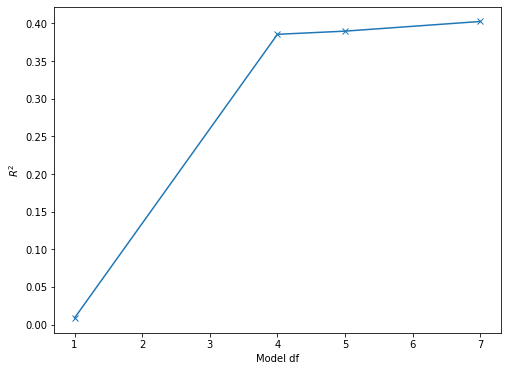

In [25]:
models = [model1, model2, model3, model4]
plt.plot([model.df_model for model in models], [model.rsquared for model in models], 'x-')
plt.xlabel("Model df")
plt.ylabel("$R^2$");